# MNIST Digit Classification with Convolutional Neural Network (CNN)

**Discipline(s):** Computer Vision, Deep Learning

colab에서 돌릴 경우, 런타임 유형을 GPU로 변경해주세요.

## 1. Import Statements

---



In [92]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import random
from tqdm import tqdm

## 2. Data Preprocessing

---



The first step is to preprocess our data.

In [93]:
BATCH_SIZE = 64
EPOCHS = 5
LEARNING_RATE = 1e-3
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)

cuda


In [94]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

In [95]:
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset  = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [96]:
X_train = train_dataset.data
y_train = train_dataset.targets
X_test = test_dataset.data
y_test = test_dataset.targets

print("Training Images:", X_train.shape)  # [60000, 28, 28]
print("Testing Images:", X_test.shape)    # [10000, 28, 28]
print("Training Labels:", y_train.shape)  # [60000]
print("Test Labels:", y_test.shape)       # [10000]

Training Images: torch.Size([60000, 28, 28])
Testing Images: torch.Size([10000, 28, 28])
Training Labels: torch.Size([60000])
Test Labels: torch.Size([10000])


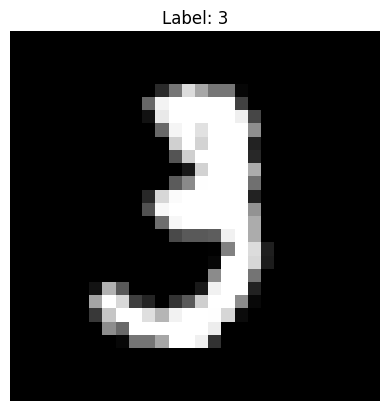

In [97]:
plt.imshow(X_train[10], cmap='gray')
plt.title(f"Label: {y_train[10].item()}")
plt.axis('off')
plt.show()

## 3. Convolutional Neural Network (CNN)

---



### 3.1. Define the Model

We then have to define our convolutional neural network.

In [98]:
# CNN 모델 정의 -> 차원이 어떻게 될지 생각하면서 코드 빈칸을 채워주세요.
class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1), # 16x28x28
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),    # 16x14x14

            # 모델을 더 깊게 쌓아도 됩니다.

            nn.Conv2d(in_channels=16, out_channels=64, kernel_size=3, stride=1, padding=1),   # 64x14x14
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),   # 64 x 7 x 7

            # fully connected layer 전, flatten 과정 필요
            nn.Flatten(),    # 64 x 7 x 7
            nn.Linear(64 * 7 * 7, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        return self.net(x)

In [99]:
# 모델 준비
model = SimpleCNN().to(DEVICE)

Once our model is defined, we can compile it using the Adam optimizer and the categorical cross-entropy loss function.

In [100]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

### 3.2. Train the Model

In [101]:
def train(model, loader):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    for x, y in loader:
        x, y = x.to(DEVICE), y.to(DEVICE)
        optimizer.zero_grad()
        output = model(x)
        loss = criterion(output, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * y.size(0)
        correct += (output.argmax(dim=1) == y).sum().item()
        total += y.size(0)

    avg_loss = total_loss / total
    accuracy = correct / total
    return avg_loss, accuracy

In [102]:
def evaluate(model, loader):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(DEVICE), y.to(DEVICE)
            output = model(x)
            loss = criterion(output, y)

            total_loss += loss.item() * y.size(0)
            correct += (output.argmax(dim=1) == y).sum().item()
            total += y.size(0)

    avg_loss = total_loss / total
    accuracy = correct / total
    return avg_loss, accuracy

In [103]:
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

for epoch in tqdm(range(EPOCHS)) :
    train_loss, train_acc = train(model, train_loader)
    test_loss, test_acc = evaluate(model, test_loader)

    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    test_losses.append(test_loss)
    test_accuracies.append(test_acc)

    print(f"[Epoch {epoch+1}] "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
          f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")

 20%|██        | 1/5 [00:15<01:00, 15.18s/it]

[Epoch 1] Train Loss: 0.1479, Train Acc: 0.9550 | Test Loss: 0.0470, Test Acc: 0.9848


 40%|████      | 2/5 [00:31<00:47, 15.69s/it]

[Epoch 2] Train Loss: 0.0433, Train Acc: 0.9862 | Test Loss: 0.0406, Test Acc: 0.9854


 60%|██████    | 3/5 [00:46<00:31, 15.53s/it]

[Epoch 3] Train Loss: 0.0307, Train Acc: 0.9903 | Test Loss: 0.0304, Test Acc: 0.9899


 80%|████████  | 4/5 [01:02<00:15, 15.54s/it]

[Epoch 4] Train Loss: 0.0219, Train Acc: 0.9929 | Test Loss: 0.0326, Test Acc: 0.9894


100%|██████████| 5/5 [01:17<00:00, 15.59s/it]

[Epoch 5] Train Loss: 0.0173, Train Acc: 0.9946 | Test Loss: 0.0299, Test Acc: 0.9900


### 3.3. 시각화

Finally, we can plot the curves.

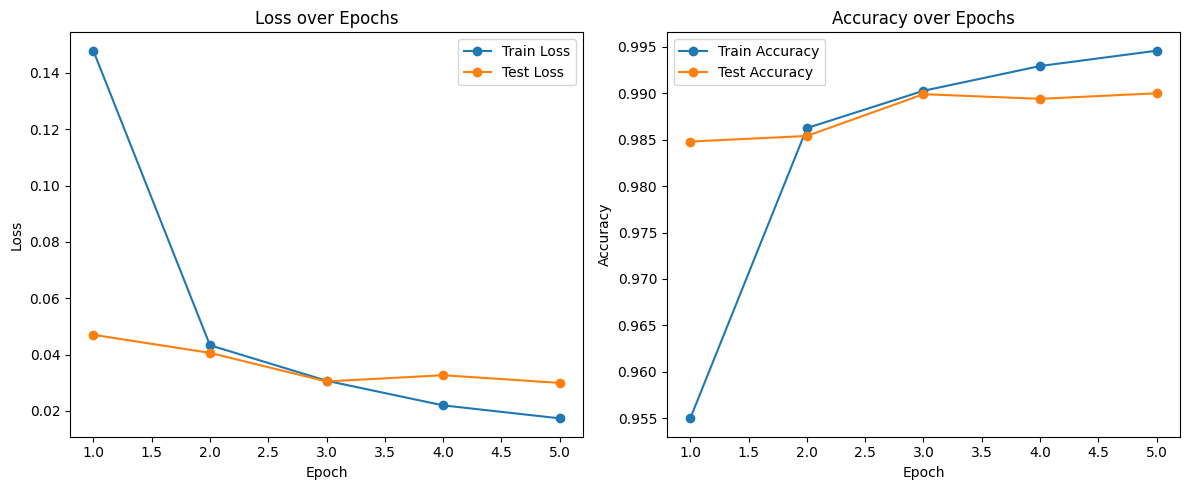

In [104]:
epochs = range(1, EPOCHS + 1)

plt.figure(figsize=(12, 5))

# Loss 그래프
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss', marker='o')
plt.plot(epochs, test_losses, label='Test Loss', marker='o')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss over Epochs")
plt.legend()

# Accuracy 그래프
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Train Accuracy', marker='o')
plt.plot(epochs, test_accuracies, label='Test Accuracy', marker='o')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy over Epochs")
plt.legend()

plt.tight_layout()
plt.show()

## 4. Make a Prediction

---



Once our model is trained, we can use it to make predictions. To do this, we first use our test set to predict the classes.

In [105]:
def show_random_predictions(model, dataset, num_images=5):
    model.eval()

    indices = random.sample(range(len(dataset)), num_images)
    images = torch.stack([dataset[i][0] for i in indices])
    labels = torch.tensor([dataset[i][1] for i in indices])

    images = images.to(DEVICE)
    outputs = model(images)
    preds = outputs.argmax(dim=1)

    plt.figure(figsize=(12, 3))
    for i in range(num_images):
        plt.subplot(1, num_images, i+1)
        plt.imshow(images[i].cpu().squeeze(), cmap='gray')
        plt.title(f"GT: {labels[i].item()}\nPred: {preds[i].item()}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

Finally, we can show a random test image with its corresponding prediction.

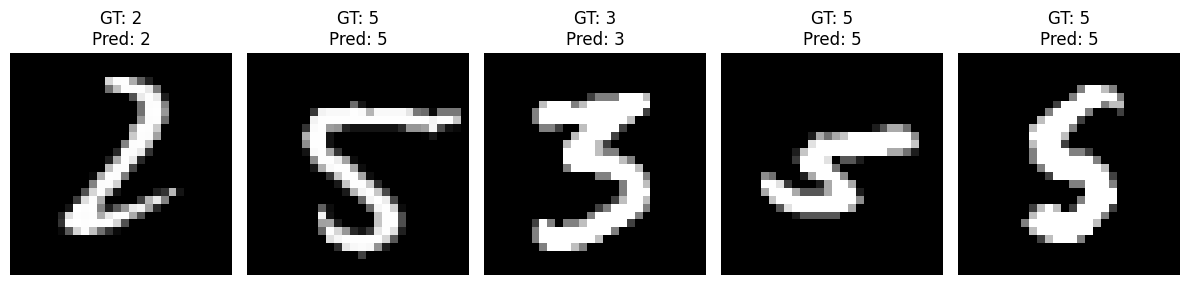

In [106]:
show_random_predictions(model, test_dataset, num_images=5)

## ResNet

In [107]:
BATCH_SIZE = 64
EPOCHS = 5
LEARNING_RATE = 1e-3
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)

cuda


In [108]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1)
        # batch normalization
        self.bn1 = nn.BatchNorm2d(out_channels)

        self.conv2 = nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.relu = nn.ReLU()


        # Skip connection: 채널 수가 다르면 어떤 convolution layer를 사용하는게 좋을지 생각해주세요.
        if in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=1, stride=1),
                nn.BatchNorm2d(out_channels)
            )
        else:
            self.shortcut = nn.Identity()

    def forward(self, x):
        identity = self.shortcut(x)

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        out += identity
        return self.relu(out)

In [109]:
class ResNetLike(nn.Module):
    def __init__(self):
        super().__init__()
        self.stem = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2)     #
        )   # 16 x 14 x 14

        # layer 등을 추가로 더 쌓으셔도 됩니다.
        self.layer1 = ResidualBlock(16, 32)
        self.layer2 = ResidualBlock(32, 64)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1)) # 64 x 1 x 1

        self.flatten = nn.Flatten()
        self.fc = nn.Linear(64, 10)

    def forward(self, x):
        out = self.stem(x)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.avgpool(out)
        out = self.flatten(out)

        return self.fc(out)

In [110]:
model = ResNetLike().to(DEVICE)

In [111]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [112]:
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

for epoch in tqdm(range(EPOCHS)) :
    train_loss, train_acc = train(model, train_loader)
    test_loss, test_acc = evaluate(model, test_loader)

    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    test_losses.append(test_loss)
    test_accuracies.append(test_acc)

    print(f"[Epoch {epoch+1}] "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
          f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")

 20%|██        | 1/5 [00:18<01:13, 18.48s/it]

[Epoch 1] Train Loss: 0.2759, Train Acc: 0.9437 | Test Loss: 0.0639, Test Acc: 0.9823


 40%|████      | 2/5 [00:37<00:56, 18.85s/it]

[Epoch 2] Train Loss: 0.0556, Train Acc: 0.9846 | Test Loss: 0.0469, Test Acc: 0.9857


 60%|██████    | 3/5 [00:56<00:37, 18.66s/it]

[Epoch 3] Train Loss: 0.0379, Train Acc: 0.9892 | Test Loss: 0.0403, Test Acc: 0.9878


 80%|████████  | 4/5 [01:15<00:18, 18.80s/it]

[Epoch 4] Train Loss: 0.0325, Train Acc: 0.9903 | Test Loss: 0.0417, Test Acc: 0.9867


100%|██████████| 5/5 [01:33<00:00, 18.69s/it]

[Epoch 5] Train Loss: 0.0285, Train Acc: 0.9917 | Test Loss: 0.0377, Test Acc: 0.9886


### 시각화

Finally, we can plot the curves.

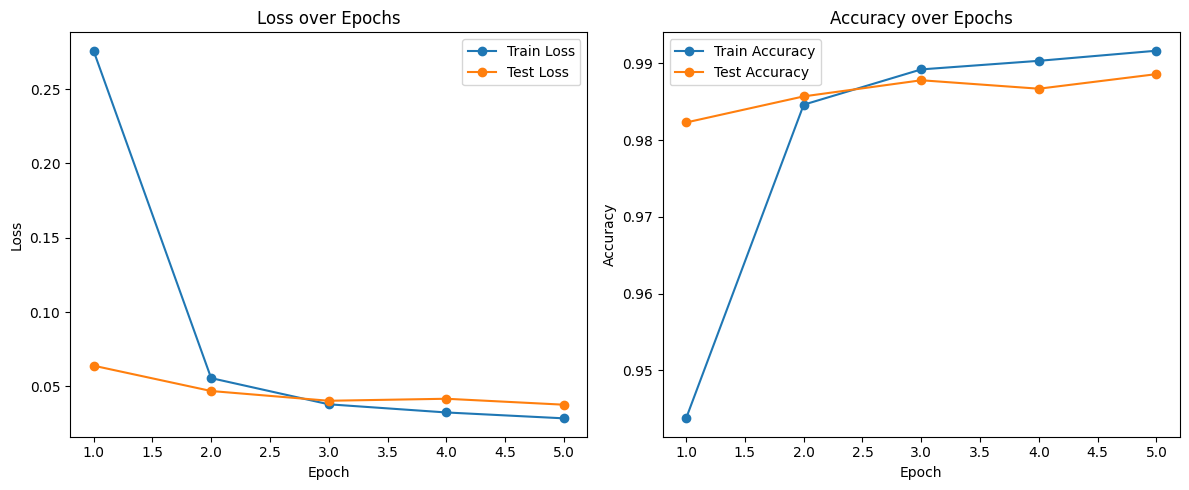

In [113]:
epochs = range(1, EPOCHS + 1)

plt.figure(figsize=(12, 5))

# Loss 그래프
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss', marker='o')
plt.plot(epochs, test_losses, label='Test Loss', marker='o')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss over Epochs")
plt.legend()

# Accuracy 그래프
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Train Accuracy', marker='o')
plt.plot(epochs, test_accuracies, label='Test Accuracy', marker='o')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy over Epochs")
plt.legend()

plt.tight_layout()
plt.show()

### Make a Prediction

---



Once our model is trained, we can use it to make predictions. To do this, we first use our test set to predict the classes.

In [114]:
def show_random_predictions(model, dataset, num_images=5):
    model.eval()

    indices = random.sample(range(len(dataset)), num_images)
    images = torch.stack([dataset[i][0] for i in indices])
    labels = torch.tensor([dataset[i][1] for i in indices])

    images = images.to(DEVICE)
    outputs = model(images)
    preds = outputs.argmax(dim=1)

    plt.figure(figsize=(12, 3))
    for i in range(num_images):
        plt.subplot(1, num_images, i+1)
        plt.imshow(images[i].cpu().squeeze(), cmap='gray')
        plt.title(f"GT: {labels[i].item()}\nPred: {preds[i].item()}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

Finally, we can show a random test image with its corresponding prediction.

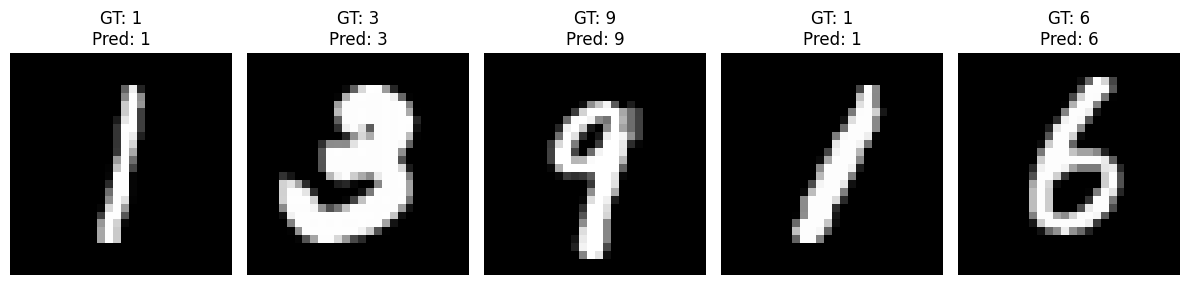

In [115]:
show_random_predictions(model, test_dataset, num_images=5)

# 다른 데이터셋으로도 진행해보기

In [153]:
BATCH_SIZE = 64
EPOCHS = 10
LEARNING_RATE = 1e-3
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)

cuda


In [154]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                         (0.2023, 0.1994, 0.2010))
])


train_dataset = datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
test_dataset  = datasets.CIFAR10(root='./data', train=False, transform=transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [155]:
X_train = train_dataset.data
y_train = train_dataset.targets
X_test = test_dataset.data
y_test = test_dataset.targets

print("Training Images:", X_train.shape)
print("Testing Images:", X_test.shape)

Training Images: (50000, 32, 32, 3)
Testing Images: (10000, 32, 32, 3)


In [156]:
print(len(y_train))

50000


## CNN

In [167]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1), # 16x32x32
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),    # 16x16x16

            # 모델을 더 깊게 쌓아도 됩니다.

            nn.Conv2d(in_channels=16, out_channels=64, kernel_size=3, stride=1, padding=1),   # 64x16x16
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),   # 64 x 8 x 8

            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),   # 128x16x16
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 128 x 4 x 4

            # fully connected layer 전, flatten 과정 필요
            nn.Flatten(),    # 64 x 8 x 8
            nn.Linear(128 * 4 * 4, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        return self.net(x)

In [168]:
model = SimpleCNN().to(DEVICE)

In [169]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [170]:
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

for epoch in tqdm(range(EPOCHS)) :
    train_loss, train_acc = train(model, train_loader)
    test_loss, test_acc = evaluate(model, test_loader)

    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    test_losses.append(test_loss)
    test_accuracies.append(test_acc)

    print(f"[Epoch {epoch+1}] "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
          f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")

 10%|█         | 1/10 [00:20<03:03, 20.40s/it]

[Epoch 1] Train Loss: 1.3704, Train Acc: 0.5037 | Test Loss: 1.0587, Test Acc: 0.6196


 20%|██        | 2/10 [00:40<02:43, 20.45s/it]

[Epoch 2] Train Loss: 0.9493, Train Acc: 0.6641 | Test Loss: 0.9144, Test Acc: 0.6788


 30%|███       | 3/10 [00:58<02:12, 18.96s/it]

[Epoch 3] Train Loss: 0.7622, Train Acc: 0.7326 | Test Loss: 0.7860, Test Acc: 0.7276


 40%|████      | 4/10 [01:14<01:47, 17.97s/it]

[Epoch 4] Train Loss: 0.6414, Train Acc: 0.7747 | Test Loss: 0.7915, Test Acc: 0.7279


 50%|█████     | 5/10 [01:31<01:28, 17.74s/it]

[Epoch 5] Train Loss: 0.5368, Train Acc: 0.8123 | Test Loss: 0.7473, Test Acc: 0.7428


 60%|██████    | 6/10 [01:48<01:09, 17.49s/it]

[Epoch 6] Train Loss: 0.4484, Train Acc: 0.8430 | Test Loss: 0.7903, Test Acc: 0.7506


 70%|███████   | 7/10 [02:06<00:52, 17.39s/it]

[Epoch 7] Train Loss: 0.3658, Train Acc: 0.8722 | Test Loss: 0.8120, Test Acc: 0.7468


 80%|████████  | 8/10 [02:23<00:34, 17.48s/it]

[Epoch 8] Train Loss: 0.3002, Train Acc: 0.8933 | Test Loss: 0.8606, Test Acc: 0.7556


 90%|█████████ | 9/10 [02:40<00:17, 17.14s/it]

[Epoch 9] Train Loss: 0.2406, Train Acc: 0.9141 | Test Loss: 0.9840, Test Acc: 0.7454


100%|██████████| 10/10 [02:57<00:00, 17.73s/it]

[Epoch 10] Train Loss: 0.1934, Train Acc: 0.9317 | Test Loss: 1.0452, Test Acc: 0.7457


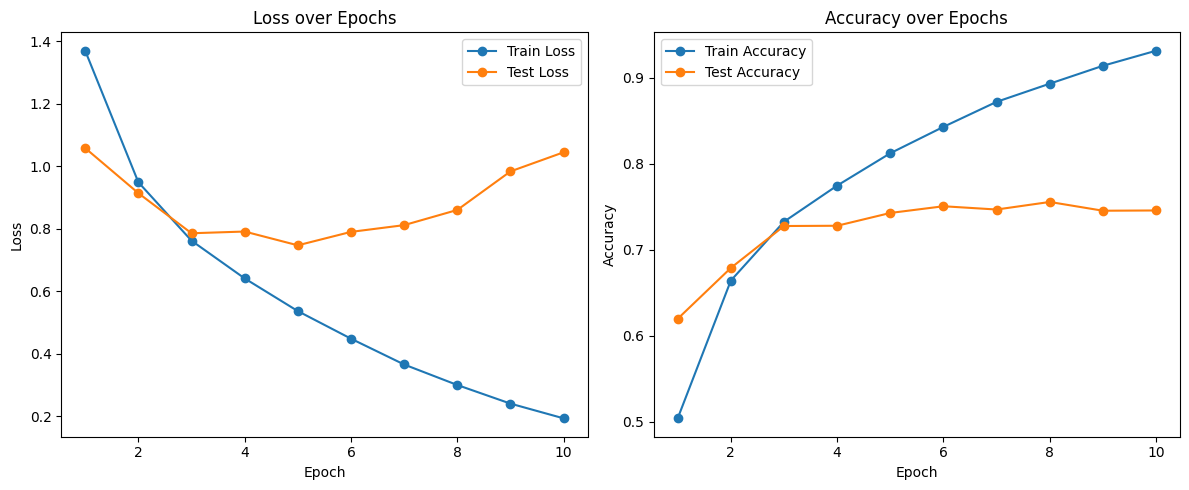

In [171]:
epochs = range(1, EPOCHS + 1)

plt.figure(figsize=(12, 5))

# Loss 그래프
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss', marker='o')
plt.plot(epochs, test_losses, label='Test Loss', marker='o')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss over Epochs")
plt.legend()

# Accuracy 그래프
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Train Accuracy', marker='o')
plt.plot(epochs, test_accuracies, label='Test Accuracy', marker='o')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy over Epochs")
plt.legend()

plt.tight_layout()
plt.show()

In [172]:
def show_random_predictions(model, dataset, num_images=5):
    model.eval()

    indices = random.sample(range(len(dataset)), num_images)
    images = torch.stack([dataset[i][0] for i in indices])
    labels = torch.tensor([dataset[i][1] for i in indices])

    images = images.to(DEVICE)
    outputs = model(images)
    preds = outputs.argmax(dim=1)

    plt.figure(figsize=(12, 3))
    for i in range(num_images):
        plt.subplot(1, num_images, i+1)
        plt.imshow(images[i].cpu().permute(1, 2, 0))
        plt.title(f"GT: {labels[i].item()}\nPred: {preds[i].item()}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()


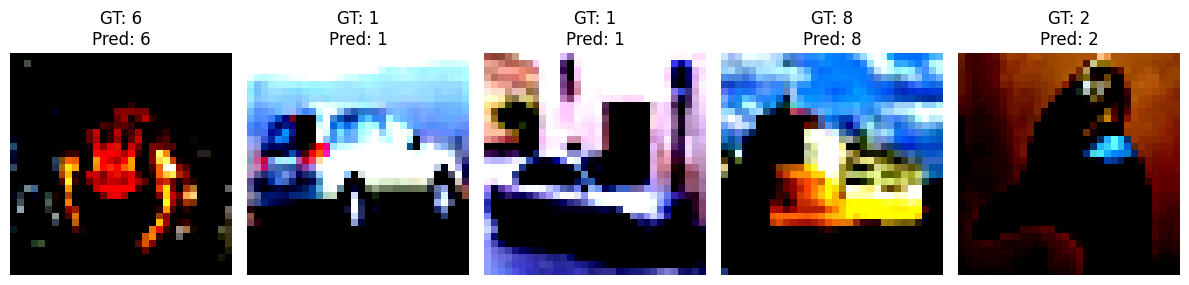

In [173]:
show_random_predictions(model, test_dataset, num_images=5)

## ResNet

In [174]:
class ResNetLike(nn.Module):
    def __init__(self):
        super().__init__()
        self.stem = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2)     #
        )   # 16 x 16 x 16

        # layer 등을 추가로 더 쌓으셔도 됩니다.
        self.layer1 = ResidualBlock(16, 32)
        self.layer2 = ResidualBlock(32, 64)
        self.layer3 = ResidualBlock(64, 128)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1)) # 128 x 1 x 1

        self.flatten = nn.Flatten()
        self.fc = nn.Linear(128, 10)

    def forward(self, x):
        out = self.stem(x)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.avgpool(out)
        out = self.flatten(out)

        return self.fc(out)

In [175]:
model = ResNetLike().to(DEVICE)

In [176]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [177]:
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

for epoch in tqdm(range(EPOCHS)) :
    train_loss, train_acc = train(model, train_loader)
    test_loss, test_acc = evaluate(model, test_loader)

    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    test_losses.append(test_loss)
    test_accuracies.append(test_acc)

    print(f"[Epoch {epoch+1}] "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
          f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")

 10%|█         | 1/10 [00:22<03:26, 22.89s/it]

[Epoch 1] Train Loss: 1.3393, Train Acc: 0.5121 | Test Loss: 1.2562, Test Acc: 0.5395


 20%|██        | 2/10 [00:44<02:59, 22.40s/it]

[Epoch 2] Train Loss: 0.9833, Train Acc: 0.6464 | Test Loss: 0.9272, Test Acc: 0.6700


 30%|███       | 3/10 [01:06<02:35, 22.15s/it]

[Epoch 3] Train Loss: 0.8391, Train Acc: 0.7028 | Test Loss: 0.8811, Test Acc: 0.6982


 40%|████      | 4/10 [01:28<02:12, 22.05s/it]

[Epoch 4] Train Loss: 0.7294, Train Acc: 0.7433 | Test Loss: 0.7403, Test Acc: 0.7452


 50%|█████     | 5/10 [01:50<01:50, 22.12s/it]

[Epoch 5] Train Loss: 0.6422, Train Acc: 0.7765 | Test Loss: 0.6957, Test Acc: 0.7576


 60%|██████    | 6/10 [02:12<01:27, 21.85s/it]

[Epoch 6] Train Loss: 0.5735, Train Acc: 0.8006 | Test Loss: 0.7852, Test Acc: 0.7342


 70%|███████   | 7/10 [02:34<01:05, 21.90s/it]

[Epoch 7] Train Loss: 0.5260, Train Acc: 0.8150 | Test Loss: 0.6440, Test Acc: 0.7800


 80%|████████  | 8/10 [02:56<00:43, 21.98s/it]

[Epoch 8] Train Loss: 0.4808, Train Acc: 0.8351 | Test Loss: 0.6100, Test Acc: 0.7910


 90%|█████████ | 9/10 [03:18<00:22, 22.03s/it]

[Epoch 9] Train Loss: 0.4470, Train Acc: 0.8460 | Test Loss: 0.6349, Test Acc: 0.7838


100%|██████████| 10/10 [03:40<00:00, 22.06s/it]

[Epoch 10] Train Loss: 0.4101, Train Acc: 0.8579 | Test Loss: 0.5791, Test Acc: 0.8043


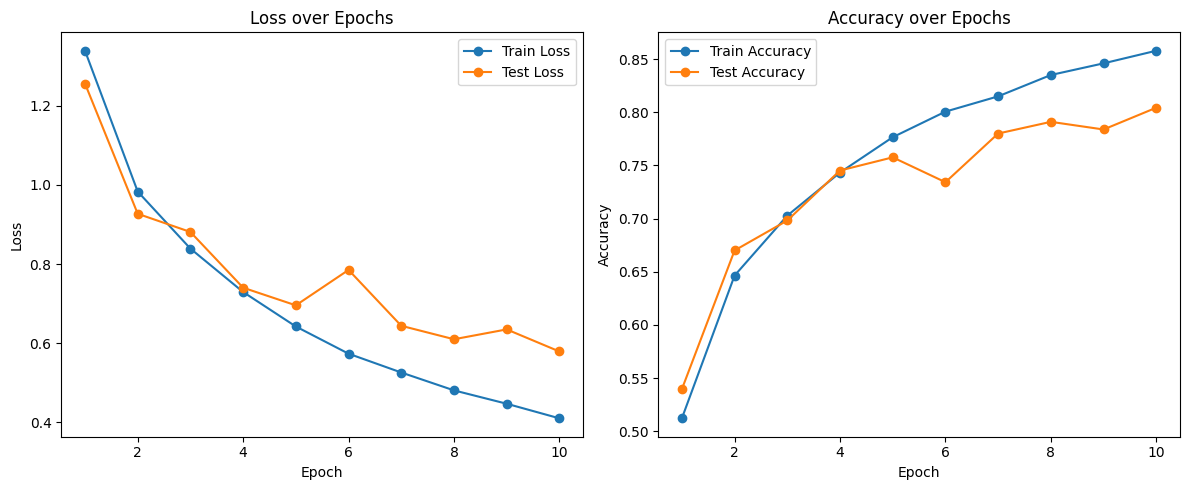

In [178]:
epochs = range(1, EPOCHS + 1)

plt.figure(figsize=(12, 5))

# Loss 그래프
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss', marker='o')
plt.plot(epochs, test_losses, label='Test Loss', marker='o')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss over Epochs")
plt.legend()

# Accuracy 그래프
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Train Accuracy', marker='o')
plt.plot(epochs, test_accuracies, label='Test Accuracy', marker='o')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy over Epochs")
plt.legend()

plt.tight_layout()
plt.show()

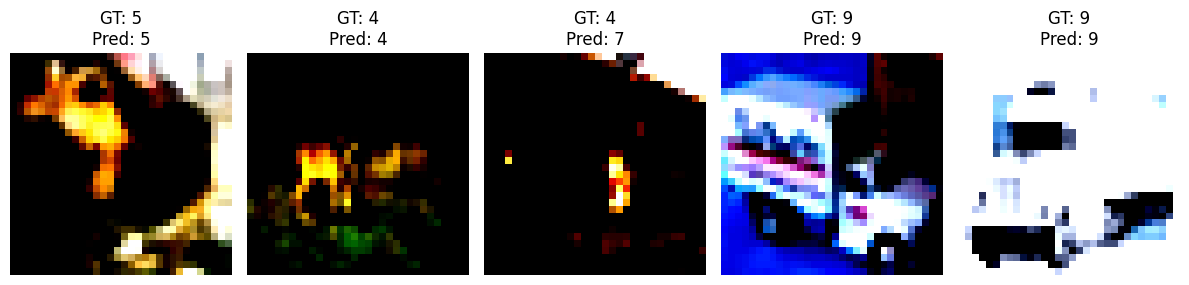

In [179]:
show_random_predictions(model, test_dataset, num_images=5)